# Homework 3 | PSTAT134 | Data Visualization & Feature Engineering
____


For this homework assignment, we'll be working with a dataset called [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/overview). It is a simulated dataset used for a popular Kaggle competition, intended to be similar to the very famous Titanic dataset. The premise of the Spaceship Titanic data is that it is currently the year 2912. You have received a transmission from four lightyears away, sent by the Spaceship Titanic, which was launched a month ago.

The Titanic set out with about 13,000 passengers who were emigrating from our solar system to three newly habitable exoplanets. However, it collided with a spacetime anomaly hidden in a dust cloud, and as a result, although the ship remained intact, half of the passengers on board were transported to an alternate dimension. Your challenge is to predict which passengers were transported, using records recovered from the spaceship's damaged computer system.

The dataset is provided in /data, along with a codebook describing each variable. You should read the dataset into your preferred coding language (R or Python) and familiarize yourself with each variable.

We will use this dataset for the purposes of practicing our data visualization and feature engineering skills.

In [283]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [285]:
#Load in data
data = pd.read_csv("data/spaceship_titanic.csv")
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

### Exercise 1
Which variables have missing values? What percentage of these variables is missing? What percentage of the overall dataset is missing?

In [288]:
missing_values = data.isnull().sum()
missing_values #We see all columns except PassengerId and Transported with missing values

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [290]:
missing_percentage = (missing_values / len(data)) * 100
missing_percentage

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [292]:
overall_missing_percentage = (data.isnull().sum().sum() / (data.shape[0] * data.shape[1])) * 100
print("The overall percentage of missing values in the data set is:", round(overall_missing_percentage,3),"%")

The overall percentage of missing values in the data set is: 1.91 %


### Exercise 2
Use mode imputation to fill in any missing values of home_planet, cryo_sleep, destination, and vip. Drop any obserations with a missing value of cabin (there are too many possible values). 

Use median imputation to fill in any missing values of age. Rather than imputing with the overall mean of age, impute with the the median age of the corresponding vip group. (For example, if someone who is a VIP is missing their age, replace their missing age value with the median age of all passengers who are also VIPs).

For passengers missing any of the expenditure variables (room_service, food_court, shopping_mall, spa, or vr_deck), handle them in this way:
- If all their observed expenditure values are 0, or if they are in cryo-sleep, replace their missing value(s) with 0.
- For the remaining missing expenditure values, use mean imputation.

In [295]:
#mode imputation for 'HomePlanet', 'CryoSleep', 'Destination', and 'VIP'
for column in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

In [297]:
#drop rows where 'Cabin' is missing
data.dropna(subset=['Cabin'], inplace=True)

In [299]:
#median imputation for 'Age' based on the VIP group
data['Age'] = data.groupby('VIP')['Age'].transform(
    lambda group: group.fillna(group.median())
)

In [301]:
expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#replace missing expenditure values with 0 if all observed values are 0 or if CryoSleep is True
for index, row in data.iterrows():
    if row[expenditure_cols].isnull().all() and (row['CryoSleep'] == True or row[expenditure_cols].sum() == 0):
        data.loc[index, expenditure_cols] = 0

#mean imputation for remaining missing expenditure values
for column in expenditure_cols:
    mean_value = data[column].mean()
    data[column].fillna(mean_value, inplace=True)

### Exercise 3
What are the proportions of both levels of the outcome variable, transported, in the training set?

In [303]:
#check for unique values in the 'Transported' column
unique_values = data['Transported'].value_counts()
proportions = unique_values / len(data)

print("Counts for each level of 'Transported':")
print(unique_values)
print("\nProportions for each level of 'Transported':")
print(proportions)

Counts for each level of 'Transported':
True     4278
False    4216
Name: Transported, dtype: int64

Proportions for each level of 'Transported':
True     0.50365
False    0.49635
Name: Transported, dtype: float64


### Exercise 4
Make proportion stacked bar charts of each of the following. Describe what patterns, if any, you observe.
- home_planet and transported
- cryo_sleep and transported
- destination and transported
- vip and transported

#### HomePlanet vs Transported

In [306]:
#calculate proportions for HomePlanet then plot
home_planet_counts = pd.crosstab(data['HomePlanet'], data['Transported'], normalize='index')

home_planet_counts.plot(kind='bar', stacked=True, figsize=(8, 5), alpha=0.8)
plt.title("Proportion Stacked Bar Chart: HomePlanet vs Transported")
plt.xlabel("HomePlanet"), plt.ylabel("Proportion"), plt.legend(title="Transported"), plt.show();

#### CryoSleep vs Transported

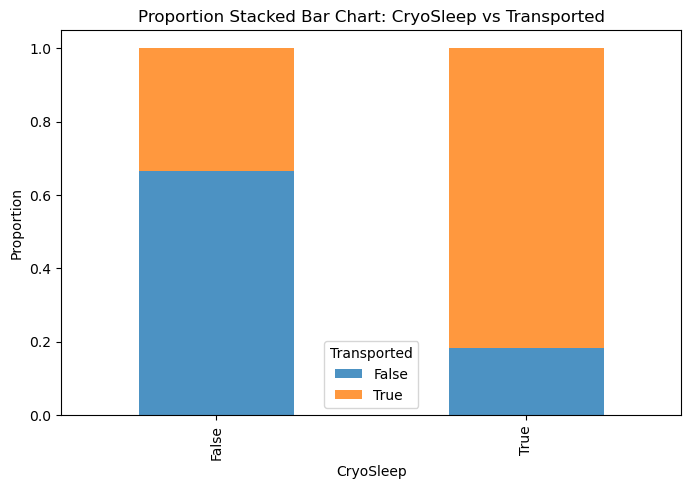

In [308]:
cryo_sleep_counts = pd.crosstab(data['CryoSleep'], data['Transported'], normalize='index')

cryo_sleep_counts.plot(kind='bar', stacked=True, figsize=(8, 5), alpha=0.8)
plt.title("Proportion Stacked Bar Chart: CryoSleep vs Transported")
plt.xlabel("CryoSleep"), plt.ylabel("Proportion"), plt.legend(title="Transported"), plt.show();

#### Destination vs Transported

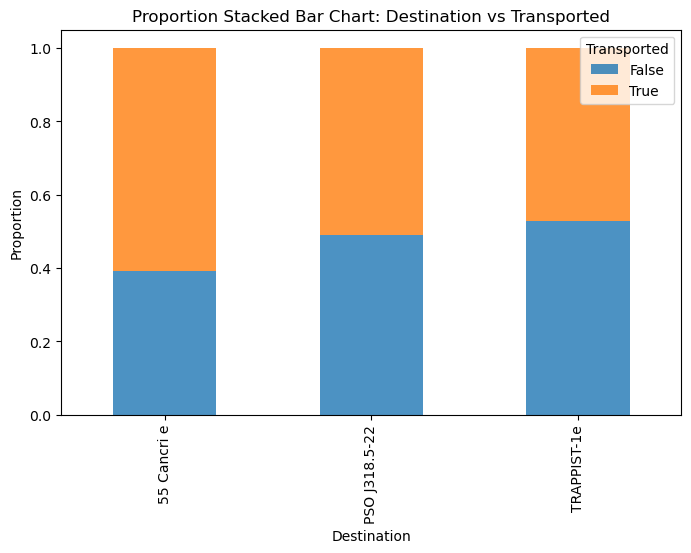

In [310]:
destination_counts = pd.crosstab(data['Destination'], data['Transported'], normalize='index')

destination_counts.plot(kind='bar', stacked=True, figsize=(8, 5), alpha=0.8)
plt.title("Proportion Stacked Bar Chart: Destination vs Transported")
plt.xlabel("Destination"), plt.ylabel("Proportion"), plt.legend(title="Transported"), plt.show();

#### VIP vs Transported

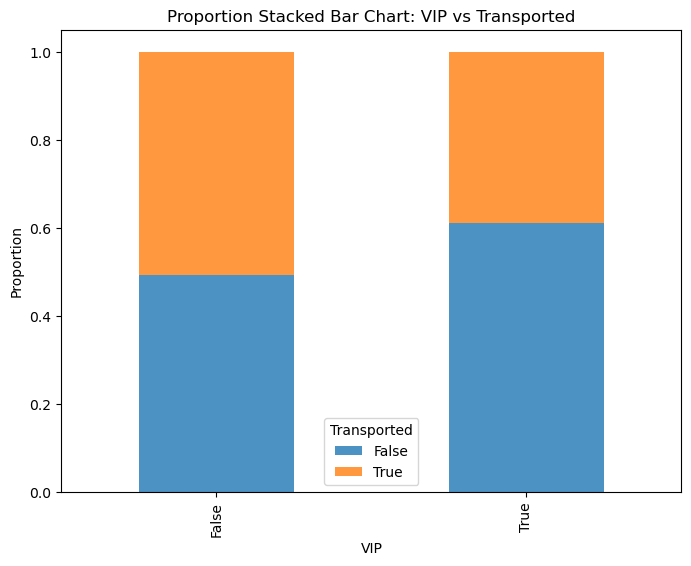

In [312]:
vip_counts = pd.crosstab(data['VIP'], data['Transported'], normalize='index')

vip_counts.plot(kind='bar', stacked=True, figsize=(8, 6), alpha=0.8)
plt.title("Proportion Stacked Bar Chart: VIP vs Transported")
plt.xlabel("VIP"), plt.ylabel("Proportion"), plt.legend(title="Transported"), plt.show();

> For the first graph, we see that HomePlanet may have some correlation with whether or not a passenger was transported as ~65% of passengers from Europa were transported to an alternate dimension compared to Earth (42%) and Mars (52%). We don't see any notable patterns when plotting VIPs and Destination vs Transportaion; however, there seems to be a significant correlation between whether or not a passenger was in cryo sleep to whether or not they were transported to an alternate dimension. It can be seen that ~81% of passengers that were in cryo sleep were transported to an alternate dimension while only ~33% of those who were not in cryo sleep were transported.

### Exercise 5
Using box plots, density curves, histograms, dot plots, or violin plots, compare the distributions of the following and describe what patterns you observe, if any.
- age across levels of transported
- room_service across levels of transported
- spa across levels of transported
- vr_deck across levels of transported

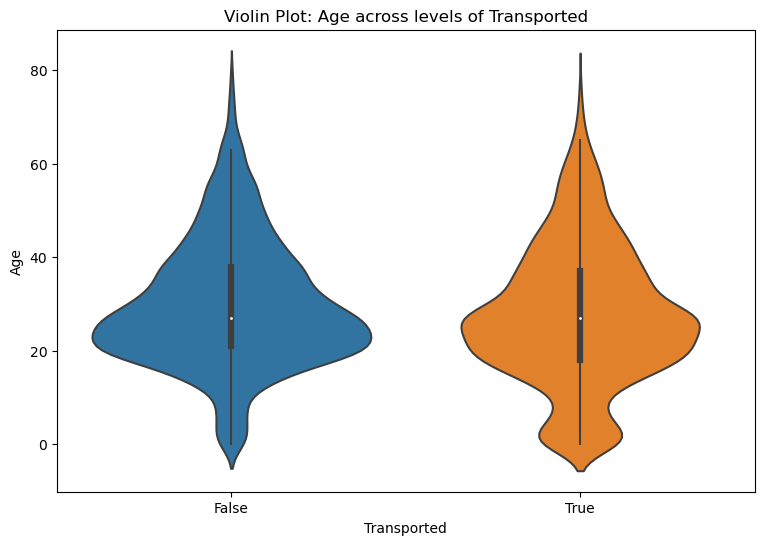

In [315]:
#violin Plot
plt.figure(figsize=(9,6))
sns.violinplot(data=data, x='Transported', y='Age', inner='box')
plt.title("Violin Plot: Age across levels of Transported")
plt.xlabel("Transported"), plt.ylabel("Age"), plt.show();

In [316]:
#density Plot
plt.figure(figsize=(9,6))
sns.kdeplot(data=data, x='RoomService', hue='Transported', common_norm=False)
plt.title("Density Plot: RoomService across levels of Transported")
plt.xlabel("RoomService"), plt.ylabel("Density"), plt.show();

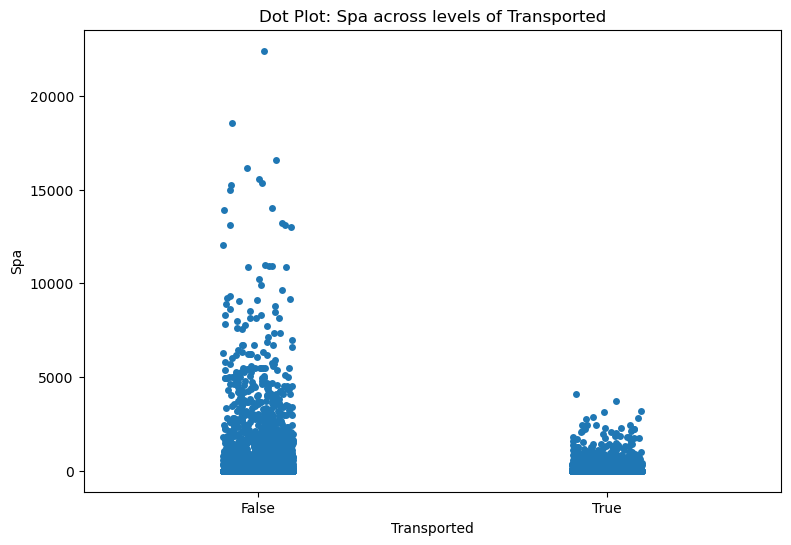

In [317]:
plt.figure(figsize=(9,6))
sns.stripplot(data=data, x='Transported', y='Spa', jitter=True)
plt.title("Dot Plot: Spa across levels of Transported")
plt.xlabel("Transported"), plt.ylabel("Spa"), plt.show();

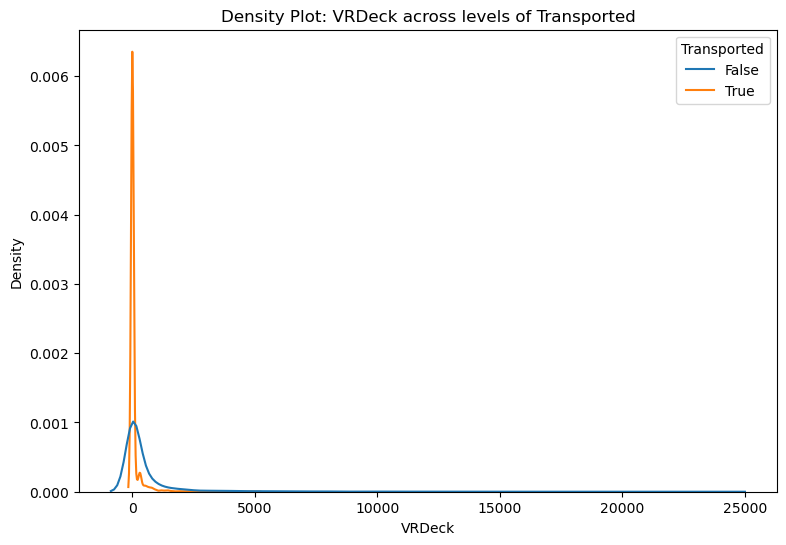

In [318]:
plt.figure(figsize=(9,6))
sns.kdeplot(data=data, x='VRDeck', hue='Transported', common_norm=False)
plt.title("Density Plot: VRDeck across levels of Transported")
plt.xlabel("VRDeck"), plt.ylabel("Density"), plt.show();

> Interpreting the graphs above, we first see that the age distribution for those who were transported and those who weren't was relatively similar with no distinguishable difference. However, when it came to spending on the various amenities provided on the ship, we see that those who did not spend money were more likely to be transported. This makes sense as those who did not spend money on amenities are most likely in cryo sleep (thus they are unable to partake) and those in cryo sleep were far more likely to be transported as seen before.

### Exercise 6
Make a correlogram of the continuous variables in the dataset. What do you observe?

In [321]:
continuous_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
#though age can technically be considered discrete
correlation_matrix = data[continuous_vars].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlogram of Continuous Variables"), plt.show();

> We see weak correlations between the continuous variables.

### Exercise 7
Use binning to divide the feature age into six groups: ages 0-12, 13-17, 18-25, 26-30, 31-50, and 51+.

In [324]:
bins = [0, 12, 17, 25, 30, 50, float('inf')]
labels = ['0-12', '13-17', '18-25', '26-30', '31-50', '51+']

data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=True)

print(data[['Age', 'AgeGroup']].head())

    Age AgeGroup
0  39.0    31-50
1  24.0    18-25
2  58.0      51+
3  33.0    31-50
4  16.0    13-17


### Exercise 8
For the expenditure variables, do the following:
- Create a new feature that consists of the total expenditure across all five amenities
- Create a binary feature to flag passengers who did not spend anything (a total expenditure of 0)
- Log-transform the total expenditure to reduce skew.

In [326]:
#create total expend
expenditure_vars = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

data['TotalExpenditure'] = data[expenditure_vars].sum(axis=1)

print(data[['TotalExpenditure']].head())

   TotalExpenditure
0               0.0
1             736.0
2           10383.0
3            5176.0
4            1091.0


In [327]:
#create binary spending indicator
data['ZeroExpenditure'] = (data['TotalExpenditure'] == 0).astype(int)

print(data[['TotalExpenditure', 'ZeroExpenditure']].head())

   TotalExpenditure  ZeroExpenditure
0               0.0                1
1             736.0                0
2           10383.0                0
3            5176.0                0
4            1091.0                0


In [328]:
#log transform
data['LogTotalExpenditure'] = np.log1p(data['TotalExpenditure'])

print(data[['TotalExpenditure', 'LogTotalExpenditure']].head())

   TotalExpenditure  LogTotalExpenditure
0               0.0             0.000000
1             736.0             6.602588
2           10383.0             9.248021
3            5176.0             8.551981
4            1091.0             6.995766


### Exercise 9
Using the passenger_id column, create a new binary-coded feature that represents whether a passenger was traveling alone or not. Make a proportion stacked bar chart of this feature and transported. What do you observe?

In [339]:
#extract the group size # from PassengerId
data['GroupSize'] = data['PassengerId'].str.split('_').str[1]
data['GroupSize'] = data['GroupSize'].astype(int)

#(1 = alone, 0 = in a group)
data['TravelingAlone'] = (data['GroupSize'] == 1).astype(int)

print(data[['PassengerId', 'GroupSize', 'TravelingAlone']].head())

  PassengerId  GroupSize  TravelingAlone
0     0001_01          1               1
1     0002_01          1               1
2     0003_01          1               1
3     0003_02          2               0
4     0004_01          1               1


In [341]:
travel_alone_counts = pd.crosstab(data['TravelingAlone'], data['Transported'], normalize='index')

travel_alone_counts.plot(kind='bar', stacked=True, figsize=(8, 6), alpha=0.8)
plt.title("Proportion Stacked Bar Chart: TravelAlone vs Transported")
plt.xlabel("Travel Alone (1 = Yes, 0 = No)"), plt.ylabel("Proportion"), plt.legend(title="Transported") , plt.show();

There seems to be no significant difference between "transported" proportions based on whether or not a passenger is traveling alone.

# Exercise 10
Using the cabin variable, extract:
1. Cabin deck (A, B, C, D, E, F, G, or T)
2. Cabin number (0 to 2000)
3. Cabin side (P or S)

Then do the following:
- Drop any observations with a cabin deck of T
- Bin cabin number into groups of 300 (for example, 0 - 300, 301 - 600, 601 - 900, etc.)

In [347]:
data[['CabinDeck', 'CabinNumber', 'CabinSide']] = data['Cabin'].str.split('/', expand=True)

data['CabinNumber'] = pd.to_numeric(data['CabinNumber'], errors='coerce')
data.head()

PassengerId HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  Transported  AgeGroup  \
0          0.0        0.0           0.0  ...        False     31-50   
1        109.0        9.0          25.0  ...         True     18-25   
2         43.0     3576.0           0.0  ...        False       51+   
3          0.0     1283.0         371.0  ...        False     31-50   
4        303.0       70.0         151.0  ...         True     13-17   

  TotalExpenditure  ZeroExpenditure LogTotalExpenditure  GroupSize  \
0              0.0                1            0.000000          1   
1            736.0                0            6.602588          1   
2          10383.0                0            9.248021          1   
3           5176.0                0            8.551981          2   
4           1091.0                0            6.995766          1   

   TravelingAlone  CabinDeck  CabinNumber  CabinSide  
0               1          B            0          P  
1               1          F            0          S  
2               1          A            0          S  
3               0          A            0          S  
4               1          F            1          S  

[5 rows x 23 columns]

In [351]:
data = data[data['CabinDeck'] != 'T']

print(data['CabinDeck'].value_counts())

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
Name: CabinDeck, dtype: int64


In [373]:
bins = [-1, 300, 600, 900, 1200, 1500, 1800, 2100]
labels = ['0-300', '301-600', '601-900', '901-1200', '1201-1500', '1501-1800', '1801-2100']

data.loc[:, 'CabinNumberBin'] = pd.cut(data['CabinNumber'], bins=bins, labels=labels, right=True)

data[['CabinNumber', 'CabinSide', 'CabinNumberBin']].head(2)

CabinNumber CabinSide CabinNumberBin
0            0         P          0-300
1            0         S          0-300

### Exercise 11
Create a new data frame that retains the following features:
1. home_planet
2. cabin deck
3. cabin number (binned)
4. cabin side
5. age (binned)
6. total expenditures (log-transformed)
7. cryo_sleep
8. destination
9. whether the passenger was traveling alone (call this solo)
To those features, do the following:
- One-hot encore all categorical features
- Center and scale all continuous features

In [376]:
selected_features = [ #new df
    'HomePlanet',         
    'CabinDeck',          
    'CabinNumberBin',    
    'CabinSide',         
    'AgeGroup',         
    'LogTotalExpenditure', 
    'CryoSleep',          
    'Destination',        
    'TravelingAlone'      
]

new_data = data[selected_features]
new_data.rename(columns={'TravelingAlone': 'Solo'}, inplace=True)

In [378]:
#one-hot encode categorical features
categorical_columns = ['HomePlanet', 'CabinDeck', 'CabinNumberBin', 'CabinSide', 'AgeGroup', 'Destination']
new_data = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)

new_data.head()

LogTotalExpenditure  CryoSleep  Solo  HomePlanet_Europa  HomePlanet_Mars  \
0             0.000000      False     1                  1                0   
1             6.602588      False     1                  0                0   
2             9.248021      False     1                  1                0   
3             8.551981      False     0                  1                0   
4             6.995766      False     1                  0                0   

   CabinDeck_B  CabinDeck_C  CabinDeck_D  CabinDeck_E  CabinDeck_F  ...  \
0            1            0            0            0            0  ...   
1            0            0            0            0            1  ...   
2            0            0            0            0            0  ...   
3            0            0            0            0            0  ...   
4            0            0            0            0            1  ...   

   CabinNumberBin_1501-1800  CabinNumberBin_1801-2100  CabinSide_S  \
0                         0                         0            0   
1                         0                         0            1   
2                         0                         0            1   
3                         0                         0            1   
4                         0                         0            1   

   AgeGroup_13-17  AgeGroup_18-25  AgeGroup_26-30  AgeGroup_31-50  \
0               0               0               0               1   
1               0               1               0               0   
2               0               0               0               0   
3               0               0               0               1   
4               1               0               0               0   

   AgeGroup_51+  Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
0             0                          0                        1  
1             0                          0                        1  
2             1                          0                        1  
3             0                          0                        1  
4             0                          0                        1  

[5 rows x 25 columns]

In [380]:
from sklearn.preprocessing import StandardScaler

continuous_features = ['LogTotalExpenditure']

scaler = StandardScaler()
new_data[continuous_features] = scaler.fit_transform(new_data[continuous_features])

new_data[continuous_features].head()

LogTotalExpenditure
0            -1.270627
1             0.573732
2             1.312704
3             1.118273
4             0.683562

### Exercise 12 
Write up your analysis thus far in one or two paragraphs. Describe what you have learned about the passengers on the Spaceship Titanic. Describe the relationships you observed between variables. Which feature do you think may be the best predictors of transported status? Why or why not?

> So far, based on the data visualizations we've made thusfar, we see a few patterns about the passengers on the Spaceship Titanic. The data suggests that the best predictor of transported status will be whether or not a passenger was in cryo sleep or not. Based on our graphs above, we see significantly higher proportions of those transported if they were in cryo sleep. Another possible predictor could be VIP status where a slight increase was seen in the proportion of those transported if they did not have VIP status. When exploring correlation between variables (more specifically amenity spending) it was surprising to see that there was weak correlation between the various amounts spent on amenities. This means that high spending in one amenity (i.e. VR) was not indicative of high spending in another. However, we also see spending in amenities in general (values over 0) would possibly another good indicator for whether or not a passenger was transported as amenity spending would only be possible if the passenger was not in cryo sleep. Though, perhaps the correlation between these two may impact the necessary assumptions for linear models? Further research would need to be done whether this is the case.